# Text Classification

In this problem you have to predict the rating of a drug based on the review and other information.

There are different types of this data in this problem. As we are interested in how you approach the data and problem, there are no descriptions of the data types, as in your work you often wont know what types of data you have an will need to think of how to interpret and model the data with little background information.

Target column - `rating`

The aim here is not to build a perfect state of the art model, we are more interested in seeing how you would go about solving a loosly defined problem and your thought process involved.

In [36]:
# pandas and numpy packages
import pandas as pd
from pandas import get_dummies
import numpy as np

# sklearn package and required libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler , Normalizer
from sklearn.base import BaseEstimator, TransformerMixin

# DenseTransformer from mlxtend package
from mlxtend.preprocessing import DenseTransformer

# plot visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# nltk package
from nltk.stem.snowball import SnowballStemmer
import nltk

# others
import re
import calendar

# disable Deprecation Warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [37]:
# loading the data into dataframe - please provide the path to .tsv file 
dr_data = pd.read_table('drugsDataRaw.tsv')

In [38]:
dr_data.head(5)

,drugName,condition,review,rating,date,usefulCount
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,"February 28, 2012",22
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,"May 17, 2009",17
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,"September 29, 2017",3
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,"March 5, 2017",35
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,"October 22, 2015",4


## Feature Analysis

In [39]:
# general information about the dataframe
print(dr_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 6 columns):
drugName       53766 non-null object
condition      53471 non-null object
review         53766 non-null object
rating         53766 non-null int64
date           53766 non-null object
usefulCount    53766 non-null int64
dtypes: int64(2), object(4)
memory usage: 2.5+ MB
None


In [40]:
# Exploring some statistics about integer columns
print(dr_data.describe())

             rating   usefulCount
count  53766.000000  53766.000000
mean       6.976900     27.989752
std        3.285207     36.172833
min        1.000000      0.000000
25%        4.000000      6.000000
50%        8.000000     16.000000
75%       10.000000     36.000000
max       10.000000    949.000000


In [41]:
print('\'review\' lenght range (words): [%d , %d]'%(min([len(x.split()) for x in dr_data['review']]),max([len(x.split()) for x in dr_data['review']])))
print('\'condition\' lenght range (words): [%d , %d]'%(min([len(str(x).split()) for x in dr_data['condition']]),max([len(str(x).split()) for x in dr_data['condition']])))
print('\'date\' range: [%s , %s]'%(min([x for x in dr_data['date']]),max([x for x in dr_data['date']])))

'review' lenght range (words): [1 , 1162]
'condition' lenght range (words): [1 , 8]
'date' range: [April 1, 2008 , September 9, 2017]


In [42]:
# number of unique and null values in each column
for cl in dr_data.columns:
    print(cl,':', dr_data[cl].nunique(),'uique values - nulls:',dr_data[dr_data[cl].isnull()][cl].count())

drugName : 2637 uique values - nulls: 0
condition : 708 uique values - nulls: 0
review : 48280 uique values - nulls: 0
rating : 10 uique values - nulls: 0
date : 3566 uique values - nulls: 0
usefulCount : 325 uique values - nulls: 0


In [43]:
# correlation of rating and usefulCount
dr_data['rating'].corr(dr_data['usefulCount'])

0.23689723074810015

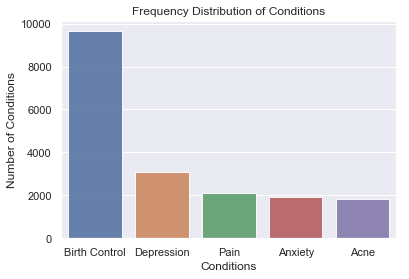

In [44]:
# plot the distribution of conditions (top 5 frequent)
cond_count = dr_data['condition'].value_counts()
sns.set(style="darkgrid")
sns.barplot(cond_count.head(5).index, cond_count.head(5).values, alpha=0.9)
plt.title('Frequency Distribution of Conditions')
plt.ylabel('Number of Conditions', fontsize=12)
plt.xlabel('Conditions', fontsize=12)
plt.show()

## Add some features

In [45]:
# add review lenght (characters count) as a new feature
dr_data['reviewLength'] = dr_data['review'].apply(len)

In [46]:
# add review lenght (words count) as a new feature
dr_data['reviewWords'] = dr_data['review'].str.lower().str.split().apply(len)

In [47]:
dr_data.head()

,drugName,condition,review,rating,date,usefulCount,reviewLength,reviewWords
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,"February 28, 2012",22,439,68
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,"May 17, 2009",17,268,48
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,"September 29, 2017",3,29,4
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,"March 5, 2017",35,782,143
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,"October 22, 2015",4,762,149


In [48]:
# to better investigate/use the date feature, we split it to day, month, and year features
# we first create a dictionary to map month name to month number
month_dict = {v: k for k,v in enumerate(calendar.month_name)}

dr_data['day']= dr_data['date'].map(lambda x: int(x.split(',')[0].split()[1]))
dr_data['month']= dr_data['date'].map(lambda x: month_dict[x.split(',')[0].split()[0]])
dr_data['year']= dr_data['date'].map(lambda x: int(x.split(',')[1]))
dr_data.head()

,drugName,condition,review,rating,date,usefulCount,reviewLength,reviewWords,day,month,year
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,"February 28, 2012",22,439,68,28,2,2012
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,"May 17, 2009",17,268,48,17,5,2009
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,"September 29, 2017",3,29,4,29,9,2017
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,"March 5, 2017",35,782,143,5,3,2017
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,"October 22, 2015",4,762,149,22,10,2015


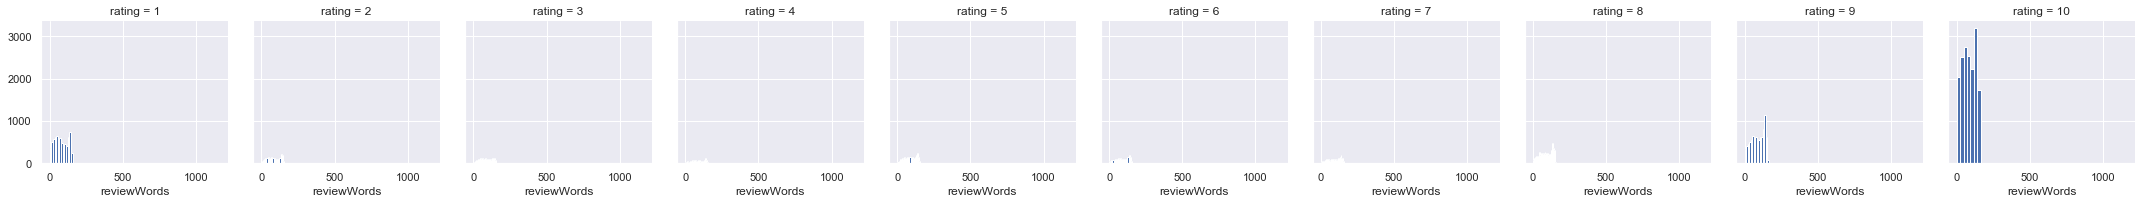

In [49]:
# visualizig the relationship betweet review length and rating
g = sns.FacetGrid(data=dr_data, col='rating')
g.map(plt.hist, 'reviewWords', bins=50)

The distribution of review length is similar across all 10 ratings. However, the number of reviews seems to be skewed a lot higher towards 10 rating. 

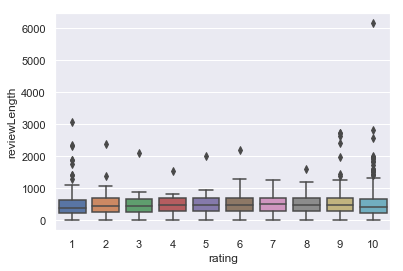

In [50]:
# we also draw a box plot for review length and rating  
sns.boxplot(x='rating', y='reviewLength', data=dr_data)

There is no much difference in review lenght distributions. So, possibly the review length won’t be such a useful feature to consider. However, we further investigate its impact later.

In [51]:
# Group the data by the rating, and see if we can find a correlation between features such as usefulCount, reviewWords, etc.
ratings = dr_data.groupby('rating').mean()
ratings.corr()

,usefulCount,reviewLength,reviewWords,day,month,year
usefulCount,1.000000,0.166572,0.206193,0.062052,-0.623558,-0.786224
reviewLength,0.166572,1.000000,0.998383,0.095790,-0.203187,-0.681211
reviewWords,0.206193,0.998383,1.000000,0.129941,-0.216044,-0.712966
day,0.062052,0.095790,0.129941,1.000000,0.505826,-0.193213
month,-0.623558,-0.203187,-0.216044,0.505826,1.000000,0.595002
year,-0.786224,-0.681211,-0.712966,-0.193213,0.595002,1.000000


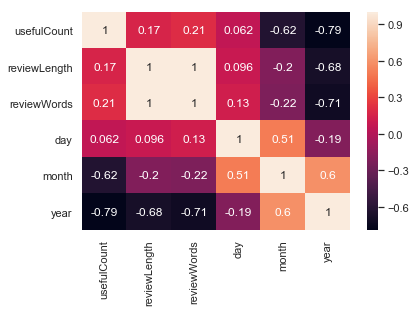

In [52]:
# plotting the correlations as a heatmap (for easier interpretation)
sns.heatmap(data=ratings.corr(), annot=True)

As we can see there is a strong correlation between number of words and number of characters in reviews (as expected), so we only consider the reviewLength (character count) in the next steps.
There is no other strong correlation between features.

## Text pre-processing

In [53]:
# we define the text_process function to clean and pre-process the text features

# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

# here we define a tokenizer and stemmer which returns the set of stems in the text that it is passed
def text_process(text,stem=False,rm_stopwords=True):
    output = []
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    output = filtered_tokens
    if stem:
        output = [stemmer.stem(t) for t in filtered_tokens]
    if rm_stopwords:
        output = [t for t in output if t.lower() not in stopwords]
    return output

In [54]:
# we process condition feature and keep the processed text in a new column 'conditionProcessed'
dr_data['conditionProcessed'] = dr_data.apply (lambda row: ' '.join(text_process(str(row['condition']))),axis=1)

In [55]:
dr_data[['condition','conditionProcessed']].head()

,condition,conditionProcessed
0,Depression,Depression
1,"Crohn's Disease, Maintenance",Crohn 's Disease Maintenance
2,Urinary Tract Infection,Urinary Tract Infection
3,Weight Loss,Weight Loss
4,Birth Control,Birth Control


In [56]:
# we process the reviews and keep the processed text in a new column 'reviewProcessed'
dr_data['reviewProcessed'] = dr_data.apply (lambda row: ' '.join(text_process(str(row['review']),stem=False)),axis=1)

In [57]:
dr_data[['review','reviewProcessed']].head()

,review,reviewProcessed
0,"""I&#039;ve tried a few antidepressants over th...",tried antidepressants years citalopram fluoxet...
1,"""My son has Crohn&#039;s disease and has done ...",son Crohn disease done well Asacol complaints ...
2,"""Quick reduction of symptoms""",Quick reduction symptoms
3,"""Contrave combines drugs that were used for al...",Contrave combines drugs used alcohol smoking o...
4,"""I have been on this birth control for one cyc...",birth control one cycle reading reviews type s...


# Text Classification

In [58]:
# splitting features and labels for classification. we load the features into 'X' and the label (rating) into 'Y'. 
X = dr_data[['conditionProcessed','reviewProcessed','reviewLength','usefulCount','day','month','year']]
Y = np.array(dr_data['rating'])
# splitting the data into training and test sets. We keep %30 of the data for test. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [59]:
# We use Sklearn's pipeline functionality to easily repeat commonly occuring 
# steps (e.g., feature extraction, feature transformation, learning) in our modeling process.

# First thing we want to do is define how to process our features. 
# The standard preprocessing in pipelines apply the same preprocessing to the whole dataset, 
# but in cases where we have heterogeneous data, this doesn't quite work. So first we create 
# some selectors/transformers that simply returns the one column in the dataset by the key value we pass.

# We define two different selectors for either text or numeric columns.

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

# We also define the following transformers/vectorizers to be used for one hot encoding and word embedding.

class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self
    
# We will implement an embedding vectorizer - a counterpart of CountVectorizer and TfidfVectorizer - 
# that is given a word -> vector mapping and vectorizes texts by taking the mean of all the vectors 
# corresponding to individual words.
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
    

In [60]:
# For each feature, we make a mini pipeline that consists of two steps: 
# 1. grab just that column from the dataset
# 2. perform proper transform on just that column and return the results.


# For review feature, we apply tf-idf vectorizer with l2-normalization and using unigram and bigrams
# (the parameters has been tuned through grid search)
review = Pipeline([
            ('review_extract' , TextSelector(key='reviewProcessed')),
            ('tfidf', TfidfVectorizer(max_features=100000,
                             stop_words='english',
                             norm='l2',use_idf=True, ngram_range=(1,2)))
        ])

# For condition feature, we apply tf-idf vectorizer without normalization and using unigram 
condition = Pipeline([
            ('cond_extract', TextSelector(key='conditionProcessed')),
            ('tfidf', TfidfVectorizer(max_features=100000,
                             stop_words='english',
                             norm=None,use_idf=True, ngram_range=(1,1)))
        ])

# For review length and usefulCount, we apply simple numerical normalizer 
reviewLen = Pipeline([
            ('reviewLength', NumberSelector(key='reviewLength')),
            ('scale', Normalizer())
        ])

useful = Pipeline([
            ('usefulCount_extract', NumberSelector(key='usefulCount')),
            ('scale', Normalizer())
        ])

# We consider day, month, and year as categorical features, and apply on-hot encodding followed by dense transformer
day = Pipeline([
            ('day_extract', NumberSelector(key='day')),
            ('one_hot', OneHotEncoder()),
            ('to_dense', DenseTransformer())
        ])

month = Pipeline([
            ('month_extract', NumberSelector(key='month')),
            ('one_hot', OneHotEncoder()),
            ('to_dense', DenseTransformer())
        ])

year = Pipeline([
            ('year_extract', NumberSelector(key='year')),
            ('one_hot', OneHotEncoder()),
            ('to_dense', DenseTransformer())
        ])


# To make a pipeline from all of our pipelines, we do the same thing, but now we 
# use a FeatureUnion to join the feature processing pipelines.
# Using a FeatureUnion, we actually parallelize the processesing/transforming our features. 
featsUnion = FeatureUnion([('review', review),
                      ('condition',condition),
                      #('reviewLen',reviewLen), # uncomment this line to include reviewLen in features
                      ('useful',useful),
                      #('day',day), # uncomment this line to include reviewLen in features
                      #('month',month), # uncomment this line to include reviewLen in features
                      #('year',year), # uncomment this line to include reviewLen in features
                     ])

# Finally, we create a classifier pipeline to generate predictions based on the given features.
classifierPipeline = Pipeline([
    ('features', review), # replace review with featsUnion to include all features for classification
    ('classifier', LogisticRegressionCV(cv=5))
])

# We have also evaluated the following classifiers: 
# ExtraTreesClassifier(n_estimators=200)
# SVC(kernel="linear")
# LogisticRegressionCV(cv=5)
# RandomForestClassifier(random_state=0, n_estimators=70)
# SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)
# however, LogisticRegressionCV (logistic regression with cross validation) achievd the best results.


In [61]:
# run the classifier pipeline and print the result
classifierPipeline = classifierPipeline.fit(X_train, Y_train)
predictions = classifierPipeline.predict(X_test)
# calculating Accuracy, MAE, MSE, RMSE
print('Accuracy: ',np.mean(predictions == Y_test))
print('MAE:',metrics.mean_absolute_error(Y_test, predictions))
print('MSE:',metrics.mean_squared_error(Y_test, predictions))
print('RMSE',np.sqrt(metrics.mean_squared_error(Y_test, predictions)))

Accuracy:  0.4735895846249225
MAE: 1.646187228766274
MSE: 8.569683818970862
RMSE 2.9274022304717304


In [62]:
# print the confusion matrix and report
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(Y_test, predictions))
print('\n')
print(classification_report(Y_test, predictions))

[[1464   50   40   12   42    8   21   74  101  398]
 [ 235  124   26    4   24   10   21   48   52  146]
 [ 195   32  108    8   20    8   26   56   52  156]
 [  95   11   32   80   29    8   14   47   49  128]
 [ 144   13   20   15  148   18   33   88   98  244]
 [  79   11   11   13   31  104   27   88  104  190]
 [  76   14   10    4   35   10  169  123  173  341]
 [  88   11   12    3   25   16   55  502  303  819]
 [ 101    8    7    6   19    8   29  225  860 1441]
 [ 152    9    8    2   16    7   41  201  588 4080]]


             precision    recall  f1-score   support

          1       0.56      0.66      0.61      2210
          2       0.44      0.18      0.25       690
          3       0.39      0.16      0.23       661
          4       0.54      0.16      0.25       493
          5       0.38      0.18      0.24       821
          6       0.53      0.16      0.24       658
          7       0.39      0.18      0.24       955
          8       0.35      0.27      0.31

In [ ]:
# Grid Search
# Here, we are creating a list of parameters for which we would like to do performance tuning. 
# All the parameters name start with the pipeline/components names the we have given. 
# E.g. features__review__tfidf__norm; here we are telling to use l1- and l2- as normalization for tfidf transformer 
# in review pipelne which itself is in features pipeline, and choose the one which is optimal.

parameters = {'features__review__tfidf__norm': ('l1','l2',None),'features__review__tfidf__ngarm_range': [(1,1),(1,2),(1,3)]}

# Pass the classifier, parameters and n_jobs=-1 which tells to use multiple cores from user machine.
gs_clf = GridSearchCV(classifierPipeline, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train,Y_train)

# Print the best score and the params
print(gs_clf.best_score_)
print(gs_clf.best_params_)

## Conclusion

We formulate the `rating prediction` as a classification problem considering multiple (heterogenous) features.
We first analysed the existing features and extended the feature space by adding review length and splitting the date to day, month, and year.
We also analysed the correlation of numeric features to see whether they are dependant or independent. 
To increase the quality of textual features we processed textual features `review` and `condition` by removing stopwords and numbers, as they have shown to decrease the accuracy of our classification.

We trained/evaluated a set of classifiers including Extra Trees Classifier, Support Vector Classifier, Logistic Regression, Random Forrest, Stochastic Gradient Descent over the features and made the following observations:
-	Logistic Regression with Cross Validation achieves the best results in terms of Accuracy, MAE, MSE, and RMSE.
-	`review` is the most (if not the only) useful feature in the classification process, with a very small improvement (~0.01 for accuracy) in performance by including `condition` and `usefulCount` features as well. However, other features have not improved the performance.

We further analysed the `review` feature and made the following observations:
-	For vectorizing `review` text, we utilized TF-IDF and Word Embedding (using pre-trained model with Glove) approaches, where TF-IDF outperformed Word Embedding by ~0.05 in accuracy. 
-	The best TF-IDF result is achieved when we apply unigrams and bigrams from the `review` text and l2-normalization of the TF-IDF vectors. We witnessed a decline in performance when choose to stem the words. 

You may run the following code for the Word Embedding-based classification of reviews. It is based on a GloVe word vector representations from the following link: http://nlp.stanford.edu/data/glove.6B.zip (bunch of small embeddings - trained on 6B tokens - 822 MB download, 2GB unzipped). 
You should unzip the dataset and put the path in GLOVE_6B_50D_PATH bellow.
A larger model can be found at http://nlp.stanford.edu/data/glove.840B.300d.zip (trained on 840B tokens - 2GB compressed, 5GB unzipped)

In [29]:
# Word Embedding-based classification of reviews

from tabulate import tabulate
%matplotlib inline
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

# preparing Training and Test sets for the classifier 
X = np.array(dr_data['reviewProcessed'])
Y = np.array(dr_data['rating'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# path to the downloaded glove word embeddings.
GLOVE_6B_50D_PATH = "C:/Users/mebrahimi/Documents/glove.6B/glove.6B.50d.txt"
encoding="utf-8"

with open(GLOVE_6B_50D_PATH, "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}
    
# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

import struct 

glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        nums=np.array(parts[1:], dtype=np.float32)
        glove_small[word] = nums

# Extra Trees classifier is one of the best choiec to stack it with word embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])


C:\Users\mebrahimi\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [30]:
# run the classifier pipeline and print the result
etree_glove_small = etree_glove_small.fit(X_train, Y_train)
predictions = etree_glove_small.predict(X_test)
# calculating Accuracy, MAE, MSE, RMSE
print('Accuracy: ',np.mean(predictions == Y_test))
print('MAE:',metrics.mean_absolute_error(Y_test, predictions))
print('MSE:',metrics.mean_squared_error(Y_test, predictions))
print('RMSE',np.sqrt(metrics.mean_squared_error(Y_test, predictions)))

Accuracy:  0.41010539367637944
MAE: 2.5970861748295104
MSE: 17.04122752634842
RMSE 4.128102170047202


In [31]:
# run the classifier pipeline and print the result
etree_glove_small_tfidf = etree_glove_small_tfidf.fit(X_train, Y_train)
predictions = etree_glove_small_tfidf.predict(X_test)
# calculating Accuracy, MAE, MSE, RMSE
print('Accuracy: ',np.mean(predictions == Y_test))
print('MAE:',metrics.mean_absolute_error(Y_test, predictions))
print('MSE:',metrics.mean_squared_error(Y_test, predictions))
print('RMSE',np.sqrt(metrics.mean_squared_error(Y_test, predictions)))

Accuracy:  0.4117172969621823
MAE: 2.5879727216367017
MSE: 16.971357718536886
RMSE 4.119630774539981


## Final Thoughts

There are more directions that worth exploring in order to further improve the performance of classification:
1. Train a word embedding model on a medical corpus and use it for vectorization. (Note: I trained a model on the given dataset, however, it has shown weak performance, mainly because of the small size of the dataset)
2. Utilize sentiment analysis packages (e.g., TextBlob, or sentiWordNet) to add a sentiment feature based on the reviews.
3. Model the problem as a regression problem and round the predictions to get the rating labels. (Note: My priliminary results have not shown any improvement)
4. Further elaborate the `usefulCount` feature to amplify the importance of `review`s. 5. Train a neural network for each feature and concatinate the output representations of all neural networks 
 as the final feature for the classification (please see our proposed framework for geolocation classification: http://www.aclweb.org/anthology/K18-1005).